# What Makes People Happy?


## Part 1: Exploratory Data Analysis and Cleaning
---


In [37]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import spacy
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
import nltk
from nltk.corpus import stopwords
import string
import re

plt.style.use('fivethirtyeight')

%matplotlib inline

### Importing data

Data from both the cleaned Happy Moments, and worker demographics will be used in the analysis. 

In [38]:
cleaned_moments = pd.read_table('./data/cleaned_hm.csv', sep=',')
workers = pd.read_table('./data/demographic.csv', sep=',')

In [39]:
happy_moments = pd.merge(cleaned_moments,workers)

## Column Information
- **hmid** (int): Happy moment ID
- **wid** (int): Worker ID
- **reflection_period** (str): Reflection period used in the instructions provided to the worker (3m or 24h)
- **original_hm** (str): Original happy moment
- **cleaned_hm** (str): Cleaned happy moment
- **modified** (bool): If True, original_hm is "cleaned up" to generate cleaned_hm (True or False)
- **predicted_category** (str): Happiness category label predicted by our classifier (7 categories. Please see the reference for details)
- **ground_truth_category** (str): Ground truth category label. The value is NaN if the ground truth label is missing for the happy moment
- **num_sentence** (int): Number of sentences in the happy moment
- **wid** (int): Worker ID
- **age** (float): Age
- **country** (str): Country of residence (follows the ISO 3166 Country Code)
- **gender** (str): {Male (m), Female (f), Other (o)}
- **marital** (str): Marital status {single, married, divorced, separated, or widowed}
- **parenthood** (str): Parenthood status {yes (y) or no (n)}

In [40]:
happy_moments.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,age,country,gender,marital,parenthood
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection,35,USA,m,single,n
1,27873,2053,24h,I played a new game that was fun and got to en...,I played a new game that was fun and got to en...,True,1,NaN,leisure,35,USA,m,single,n
2,28073,2053,24h,I listened to some music and heard an entire a...,I listened to some music and heard an entire a...,True,1,NaN,leisure,35,USA,m,single,n
3,33522,2053,24h,Went to see a movie with my friend,Went to see a movie with my friend,True,1,NaN,bonding,35,USA,m,single,n
4,34522,2053,24h,"Played guitar, learning a song on it","Played guitar, learning a song on it",True,1,NaN,leisure,35,USA,m,single,n


In [41]:
happy_moments.shape

(100535, 14)

In [42]:
happy_moments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100535 entries, 0 to 100534
Data columns (total 14 columns):
hmid                     100535 non-null int64
wid                      100535 non-null int64
reflection_period        100535 non-null object
original_hm              100535 non-null object
cleaned_hm               100535 non-null object
modified                 100535 non-null bool
num_sentence             100535 non-null int64
ground_truth_category    14125 non-null object
predicted_category       100535 non-null object
age                      100442 non-null object
country                  100332 non-null object
gender                   100456 non-null object
marital                  100378 non-null object
parenthood               100457 non-null object
dtypes: bool(1), int64(3), object(10)
memory usage: 10.8+ MB


**Note:** Before cleaning the data, the data set had 100,535 rows, and 14 columns.


---

## Data Cleaning

>Given the size of the data set, and the timeframe to analyze it, rows in which worker's information had null values were dropped. 



Age was listed as an object, so it was changed to a float, or null if it could not be converted. 
Workers who reported to be over 100 years old were also dropped.

In [43]:
def converter(s):
    try:
        output = float(s)
    except:
        output = np.nan
    return output

In [44]:
happy_moments['age']=happy_moments.age.apply(converter)

In [45]:
happy_moments = happy_moments[happy_moments['age']<100]

All rows that contained null values for Age, Country, Gender, Parenthood, or Marital were dropped.

In [46]:
happy_moments = happy_moments.dropna(subset=['age','country','gender','parenthood','marital'])

In [47]:
happy_moments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99974 entries, 0 to 100534
Data columns (total 14 columns):
hmid                     99974 non-null int64
wid                      99974 non-null int64
reflection_period        99974 non-null object
original_hm              99974 non-null object
cleaned_hm               99974 non-null object
modified                 99974 non-null bool
num_sentence             99974 non-null int64
ground_truth_category    14038 non-null object
predicted_category       99974 non-null object
age                      99974 non-null float64
country                  99974 non-null object
gender                   99974 non-null object
marital                  99974 non-null object
parenthood               99974 non-null object
dtypes: bool(1), float64(1), int64(3), object(9)
memory usage: 10.8+ MB


Columns unrelated to the analysis were dropped.

In [48]:
happy_moments.drop(columns=['ground_truth_category','original_hm','modified'],inplace=True)

## Exploratory Data Analysis

In [49]:
happy_moments.describe()

,hmid,wid,num_sentence,age
count,99974.000000,99974.000000,99974.000000,99974.000000
mean,78223.663352,2720.198322,1.340018,32.392812
std,29180.846455,3513.769235,1.296365,9.914971
min,27673.000000,1.000000,1.000000,2.000000
25%,52936.250000,408.000000,1.000000,26.000000
50%,78249.500000,1117.000000,1.000000,30.000000
75%,103504.750000,3424.750000,1.000000,36.000000
max,128766.000000,13839.000000,69.000000,98.000000


In [50]:
happy_moments.describe(include ='object')

,reflection_period,cleaned_hm,predicted_category,country,gender,marital,parenthood
count,99974,99974,99974,99974,99974,99974,99974
unique,2,95946,7,100,3,5,2
top,3m,I WENT TO TEMPLE,affection,USA,m,single,n
freq,50400,120,33903,78740,57496,53935,60695


>**Note:** Duplicated Happy Moments will be addressed at a later point, depending on their effects to the model.

#### Predicted Categories
These are the 7 predicted categories under which the previous researchers classified the happy moments:

In [51]:
happy_moments.predicted_category.value_counts()

affection           33903
achievement         33826
enjoy_the_moment    11093
bonding             10687
leisure              7432
nature               1835
exercise             1198
Name: predicted_category, dtype: int64

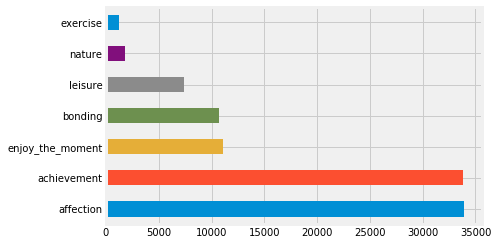

In [52]:
happy_moments.predicted_category.value_counts().plot(kind='barh');



#### Comparison of Reflection Periods

In [53]:
happy_moments.reflection_period.value_counts()

3m     50400
24h    49574
Name: reflection_period, dtype: int64

In [54]:
three_month_hm = happy_moments[happy_moments['reflection_period']=='3m']
twenty_four_hour_hm = happy_moments[happy_moments['reflection_period']=='24h']

##### Happy Moments experienced over three months

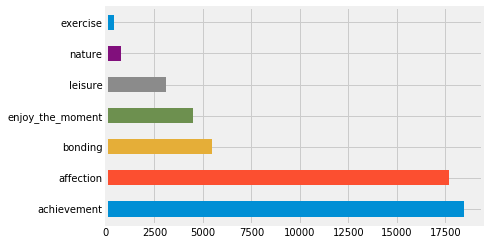

In [55]:
three_month_hm.predicted_category.value_counts().plot(kind='barh');

##### Happy Moments experienced over twenty-four hours

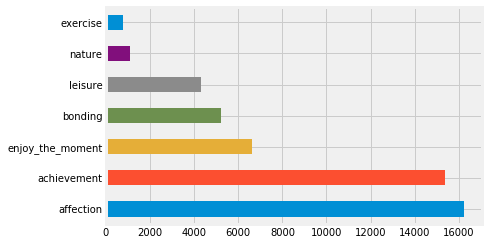

In [56]:
twenty_four_hour_hm.predicted_category.value_counts().plot(kind='barh');

>**Note:** Most experiences recalled over twenty-four Hours related to Affection, whereas most experiences recalled over three Months related to Achievement

#### Age Distribution of Workers

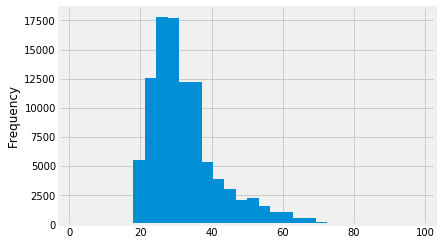

In [57]:
#The distribution of Workers ages are right-skewed
happy_moments.age.plot(kind='hist',bins=30);

In [58]:
#The average age of a Worker is around 32.
happy_moments.age.mean()

32.3928121311541

In [59]:
#The median age of all workers is 30.
happy_moments.age.median()

30.0

#### Comparison of Genders Identified by Workers

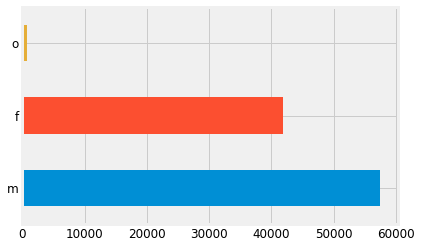

In [60]:
happy_moments.gender.value_counts().plot(kind='barh',fontsize=12);

In [61]:
male_hm = happy_moments[happy_moments['gender']=='m']
female_hm = happy_moments[happy_moments['gender']=='f']

##### Happy Moments experienced by Males

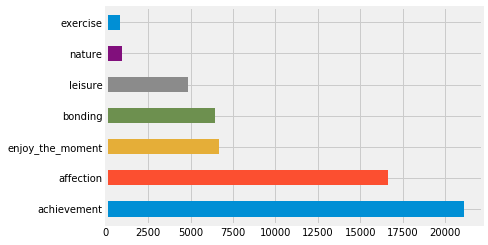

In [62]:
male_hm.predicted_category.value_counts().plot(kind='barh');

##### Happy Moments experienced by Females

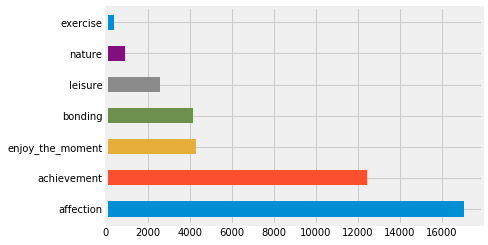

In [63]:
female_hm.predicted_category.value_counts().plot(kind='barh');

>**Note:** Men reported Achievement as making them Happy the most often, whereas Women reported Affection most often

## Data Cleaning for NLP

In [64]:
happy_moments['category_id'] = happy_moments.predicted_category.factorize()[0]

In [65]:
happy_moments.head()

,hmid,wid,reflection_period,cleaned_hm,num_sentence,predicted_category,age,country,gender,marital,parenthood,category_id
0,27673,2053,24h,I went on a successful date with someone I fel...,1,affection,35.0,USA,m,single,n,0
1,27873,2053,24h,I played a new game that was fun and got to en...,1,leisure,35.0,USA,m,single,n,1
2,28073,2053,24h,I listened to some music and heard an entire a...,1,leisure,35.0,USA,m,single,n,1
3,33522,2053,24h,Went to see a movie with my friend,1,bonding,35.0,USA,m,single,n,2
4,34522,2053,24h,"Played guitar, learning a song on it",1,leisure,35.0,USA,m,single,n,1


In [66]:
nlp = spacy.load('en_core_web_sm')
STOPLIST = set(stopwords.words('english') + ["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve"]

In [67]:
def tokenizeText(sample):

    # get the tokens using spaCy
    for sentences in sample:
        tokens = nlp.tokenizer(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    
    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")

    return tokens

### Commented out calling the 'tokenizeText' function due to the length of time it takes to run

In [68]:
#happy_moments['toke_text'] = happy_moments['cleaned_hm'].apply(tokenizeText)

### Export To CSV

In [69]:
#happy_moments.to_csv('../data/happy_moments.csv',index=False)